# Atlas mapping

In [1]:
from ibllib.atlas import AllenAtlas
from ibllib.atlas.regions import BrainRegions
ba = AllenAtlas()
br = BrainRegions() # br is also an attribute of ba so could to br = ba.regions

## Available Mappings
Three mappings are currently available within the IBL, these are:

1. Allen Atlas - total of xx annotation regions provided by Allen Atlas
2. Beryl Atlas - total of xx annotation regions
3. Cosmos Atlas - total of 8 annotation regions

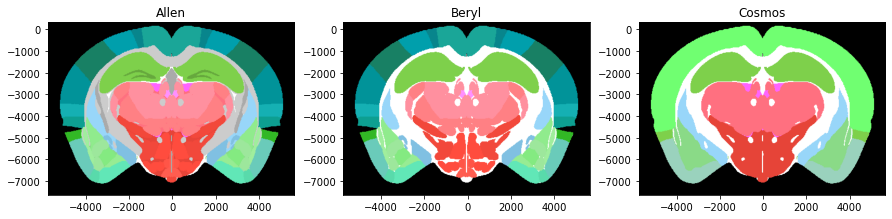

In [2]:
# create figure
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 18))

# plot coronal slice at ap = -2000 um
ap = -2000 / 1e6
# Allen mapping
ba.plot_cslice(ap, volume='annotation', mapping='Allen', ax=axs[0])
_ = axs[0].set_title('Allen')
# Beryl mapping
ba.plot_cslice(ap, volume='annotation', mapping='Beryl', ax=axs[1])
_ = axs[1].set_title('Beryl')
# Cosmos mapping
ba.plot_cslice(ap, volume='annotation', mapping='Cosmos', ax=axs[2])
_ = axs[2].set_title('Cosmos')

## Understanding the mappings
The mappings store the highest level annotation (or parent node) that should be considered. Any regions that are children of these nodes are assigned the same annotation as their parent. 

For example, consider the region with the acronym **MDm** (Mediodorsal nucleus of the thalamus, medial part). Firstly, to navigate ourselves, we can find the acronyms of all the ancestors to this region,

In [3]:
# First find the atlas_id associated with acronym MDm
atlas_id = br.acronym2atlasID('MDm')
# Then find the acronyms of the ancestors of this region
print(br.ancestors(ids=atlas_id)['acronym'])

['root' 'grey' 'BS' 'IB' 'TH' 'DORpm' 'MED' 'MD' 'MDm']


We can then take a look at what acronym this region will assigned under the different mappings. Under the Allen mapping we expect it to be assigned the same acronym as this is the lowest level region parcelation that we use.

In [4]:
print(br.acronym2acronym('MDm', mapping='Allen'))

['MDm']


Under the Beryl mapping, **MDm** is given the acronym of it's parent, **MD**

In [5]:
print(br.acronym2acronym('MDm', mapping='Beryl'))

['MD']


Under the Cosmos mapping, it is assigned to the region **TH**

In [6]:
print(br.acronym2acronym('MDm', mapping='Cosmos'))

['TH']


Therefore any clusters that are assigned an acronym **MDm** in the Allen mapping, will instead be assigned to the region **MD** in the Beryl mapping and **TH** in the Cosmos mapping. 

If a region is not included in a mapping, the value for this region is set to root. For example **TH** is not included in the Beryl mapping

In [7]:
print(br.acronym2acronym('TH', mapping='Beryl'))

['root']


## Lateralisation
Lateralised versions of each of the three mappings are also available. This allow regions on the left and right hemispheres of the brain to be differentiated. 

The convention used is that regions in the left hemisphere have negative atlas ids whereas those on the right hemisphere have positive atlas ids.

For the non lateralised mappings the atlas id is always positive regardless of whether the region lies in the left or right hemisphere. Aggregating values over regions could result, therefore, in values from different hemispheres being considered together.

One thing to be aware of, is that while lateralised mappings return distinct atlas ids for the left and right hemispheres, the acronyms returned are not lateralised. 

For example consider findng the atlas id when mapping the acronym **MDm** onto the Beryl atlas. When specifying the left hemisphere, the returned atlas id is negative

In [8]:
# Left hemisphere gives negative atlas id
print(br.acronym2atlasID('MDm', mapping='Beryl', hemisphere='left'))

[-362]


When specifying the right hemisphere, the returned atlas id is positive

In [9]:
# Left hemisphere gives negative atlas id
print(br.acronym2atlasID('MDm', mapping='Beryl', hemisphere='right'))

[362]


However, when converting from atlas id to acronym, regardless of whether we specify a negative (left hemisphere) or positive (right hemisphere) value, the returned acronym is always the same

In [10]:
print(br.atlasID2acronym(-362, mapping='Beryl'))

['MD']


In [11]:
print(br.atlasID2acronym(362, mapping='Beryl'))

['MD']


## How to map your data

### Mapping from mlapdv coordinates
The recommended and most versatile way to find the locations of clusters under different mappings is to use the mlapdv coordinates of the clusters. Given a probe insertion id, the clusters object can be loaded in using the following code

In [12]:
from brainbox.io.one import SpikeSortingLoader
from one.api import ONE
one = ONE()

pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'

sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

You will find that the cluster object returned already contains an atlas_id attribute. These are the atlas ids that are obtained using the default mapping - **non lateralised Allen**. For this mapping regardless of whether the clusters lie in the right or left hemisphere the clusters are assigned positive atlas ids

In [13]:
print(clusters['atlas_id'][0:10])

[596 596 596 596 596 596 596 596 596 596]


We can obtain the mlapdv coordinates of the clusters and explore in which hemisphere the clusters lie

In [14]:
import numpy as np
mlapdv = np.c_[clusters['x'], clusters['y'], clusters['z']] # x = ml, y = ap, z = dv
clus_LH = np.sum(mlapdv[:, 0] < 0)
clus_RH = np.sum(mlapdv[:, 0] > 0)
print(f'Total clusters = {len(mlapdv)}, LH clusters = {clus_LH}, RH clusters = {clus_RH}')

Total clusters = 914, LH clusters = 914, RH clusters = 0


To get a better understanding of the difference between using lateralised and non-lateralised mappings, let's also make a manipulated version of the mlapdv positions where the first 5 clusters have been moved into the right hemisphere and call this `mlapdv_rh`

In [15]:
mlapdv_rh = np.copy(mlapdv)
mlapdv_rh[0:5, 0] = -1 * mlapdv_rh[0:5, 0]
clus_LH = np.sum(mlapdv_rh[:, 0] < 0)
clus_RH = np.sum(mlapdv_rh[:, 0] > 0)
print(f'Total clusters = {len(mlapdv_rh)}, LH clusters = {clus_LH}, RH clusters = {clus_RH}')

Total clusters = 914, LH clusters = 909, RH clusters = 5


To find the locations of the clusters in the brain from the mlapdv position we can use the [get_labels](https://int-brain-lab.github.io/iblenv/_autosummary/ibllib.atlas.atlas.html#ibllib.atlas.atlas.BrainAtlas.get_labels) method in the AllenAtlas object. First let's explore the output of using a non lateralised mapping.

In [16]:
atlas_id_Allen = ba.get_labels(mlapdv, mapping='Allen')
atlas_id_Allen_rh = ba.get_labels(mlapdv_rh, mapping='Allen')
print(f'Non-lateralised Allen mapping ids using mlapdv: {atlas_id_Allen[0:10]}')
print(f'Non-lateralised Allen mapping ids using mlapdv_rh: {atlas_id_Allen_rh[0:10]}')

Non-lateralised Allen mapping ids using mlapdv: [596 596 596 596 596 596 596 596 596 596]
Non-lateralised Allen mapping ids using mlapdv_rh: [596 596 596 596 596 596 596 596 596 596]


Notice that regardless of whether the clusters lie in the left or right hemisphere the sign of the atlas id is the same. The result of this mapping is also equivalent the default output from `clusters['atlas_id`]

In [17]:
np.array_equal(clusters['atlas_id'], atlas_id_Allen)

True

Now if we use the lateralised mapping, we notice that the clusters in the left hemisphere have been assigned negative atlas ids whereas those in the right hemisphere have positive atlas ids

In [18]:
atlas_id_Allen = ba.get_labels(mlapdv, mapping='Allen-lr')
atlas_id_Allen_rh = ba.get_labels(mlapdv_rh, mapping='Allen-lr')
print(f'Lateralised Allen mapping ids using mlapdv: {atlas_id_Allen[0:10]}')
print(f'Lateralised Allen mapping ids using mlapdv_rh: {atlas_id_Allen_rh[0:10]}')

Lateralised Allen mapping ids using mlapdv: [-596 -596 -596 -596 -596 -596 -596 -596 -596 -596]
Lateralised Allen mapping ids using mlapdv_rh: [ 596  596  596  596  596 -596 -596 -596 -596 -596]


By changing the mapping argument that we pass in, we can also easily obtain the atlas ids for the Beryl and Cosmos mappings

In [19]:
atlas_id_Beryl = ba.get_labels(mlapdv_rh, mapping='Beryl-lr')
atlas_id_Cosmos = ba.get_labels(mlapdv_rh, mapping='Cosmos')
print(f'Lateralised Beryl mapping ids using mlapdv_rh: {atlas_id_Beryl[0:10]}')
print(f'Non-lateralised Cosmos mapping ids using mlapdv_rh: {atlas_id_Cosmos[0:10]}')

Lateralised Beryl mapping ids using mlapdv_rh: [ 596  596  596  596  596 -596 -596 -596 -596 -596]
Non-lateralised Cosmos mapping ids using mlapdv_rh: [623 623 623 623 623 623 623 623 623 623]


### Mapping from atlas ids
Methods are available that allow you to translate atlas ids from one mapping to another. 

In [20]:
# map atlas ids from lateralised Allen to lateralised Beryl
atlas_id_Allen = ba.get_labels(mlapdv_rh, mapping='Allen-lr') # lateralised Allen

remap_beryl = br.atlasID2atlasID(atlas_id_Allen, mapping='Beryl-lr')
print(f'Lateralised Beryl mapping ids using remap: {remap_beryl[0:10]}')

# map atlas ids from lateralised Allen to non-lateralised Cosmos
remap_cosmos = br.atlasID2atlasID(atlas_id_Allen_rh, mapping='Cosmos')
print(f'Non-lateralised Cosmos mapping ids using remap: {remap_cosmos[0:10]}')

Lateralised Beryl mapping ids using remap: [ 596  596  596  596  596 -596 -596 -596 -596 -596]
Non-lateralised Cosmos mapping ids using remap: [623 623 623 623 623 623 623 623 623 623]


When remapping with atlas ids it is not possible to map from 
1. A non-lateralised to a lateralised mapping. 
2. From a higher mapping to a lower one (e.g cannot map from Beryl to Allen, or Cosmos to Allen)
3. From Beryl to Cosmos

This is why it is recommened to use mlapdv coordinates for remappings as it allows complete flexibility

### Converting to acronyms
Methods are available to convert between atlas ids and acronyms. Note that when converting to acronyms, even if the atlas ids are lateralised the returned acronyms are not

In [21]:
atlas_id_Allen = ba.get_labels(mlapdv_rh, mapping='Allen-lr') # lateralised Allen
acronym_Allen = br.atlasID2acronym(atlas_id_Allen)
print(f'Acronyms of lateralised Allen ids: {acronym_Allen[0:10]}')

atlas_id_Allen = ba.get_labels(mlapdv_rh, mapping='Allen') # Non-ateralised Allen
acronym_Allen = br.atlasID2acronym(atlas_id_Allen)
print(f'Acronyms of non-lateralised Allen: {acronym_Allen[0:10]}')

Acronyms of lateralised Allen ids: ['NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB']
Acronyms of non-lateralised Allen: ['NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB' 'NDB']


It is also possible to simultaneously remap the acronyms with these methods

In [22]:
acronym_Cosmos = br.atlasID2acronym(atlas_id_Allen, mapping='Cosmos-lr')
print(acronym_Cosmos[0:10])

['CNU' 'CNU' 'CNU' 'CNU' 'CNU' 'CNU' 'CNU' 'CNU' 'CNU' 'CNU']
